# Sklearn

## Bike Sharing Demand
Задача на kaggle: https://www.kaggle.com/c/bike-sharing-demand

По историческим данным о прокате велосипедов и погодных условиях необходимо спрогнозировтаь спрос на прокат велосипедов.

В исходной постановке задачи доступно 11 признаков: https://www.kaggle.com/c/prudential-life-insurance-assessment/data

В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные. 

Для демонстрации используется обучающая выборка из исходных данных train.csv, файлы для работы прилагаются.

### Библиотеки

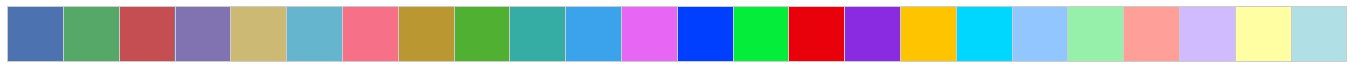

In [73]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
from contextlib import contextmanager

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

# will be in numpy >= 1.15
@contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    try:
        yield
    finally: 
        np.set_printoptions(**original)
        
def ndprint(a, precision=3):
    with printoptions(precision=precision, suppress=True):
        print(a)


In [2]:
from sklearn import datasets, linear_model, metrics, model_selection as mdsel, pipeline, preprocessing

### Загрузка данных

In [283]:
raw_data = pd.read_csv('data/13_14_bike_sharing_demand_train.csv', header = 0, sep = ',')

In [284]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### Предобработка данных

#### Обучение и отложенный тест

In [285]:
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)

In [288]:
raw_data['month'] = raw_data.datetime.dt.month
raw_data['week'] = raw_data.datetime.dt.week
raw_data['hour'] = raw_data.datetime.dt.hour

NameError: name 'log' is not defined

In [292]:
raw_data['count'] = raw_data['count'].apply(np.log)

In [293]:
train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]

In [294]:
raw_data.shape, train_data.shape, hold_out_test_data.shape

((10886, 15), (9886, 15), (1000, 15))

In [295]:
#обучение
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

In [296]:
#тест
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

In [297]:
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype = bool)

In [298]:
print(binary_data_columns)
print(binary_data_indices)

['holiday', 'workingday']
[False  True  True False False False False False False False False]


In [299]:
categorical_data_columns = ['weather', 'month'] 
categorical_data_indices = np.array([(column in categorical_data_columns) for column in train_data.columns], dtype = bool)

In [300]:
print(categorical_data_columns)
print(categorical_data_indices)

['weather', 'month']
[False False False  True False False False False  True False False]


In [301]:
numeric_data_columns = ['temp', 'humidity', 'windspeed', 'hour', 'week']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)

In [302]:
print(numeric_data_columns)
print(numeric_data_indices)

['temp', 'humidity', 'windspeed', 'hour', 'week']
[False False False False  True False  True  True False  True  True]


### Pipeline

In [303]:
regressor = linear_model.SGDRegressor(random_state = 0, max_iter = 50, tol = 1e-3, loss = 'squared_loss', penalty = 'l2',)

In [304]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [305]:
estimator.fit(train_data, train_labels)

Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x00000177F32787B8>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
         ...
       power_t=0.25, random_state=0, shuffle=True, tol=0.001, verbose=0,
       warm_start=False))])

In [308]:
predictions = estimator.predict(test_data)
# predictions = [max(x, 0.) for x in predictions]

In [309]:
metrics.mean_absolute_error(test_labels, predictions)

0.9521545706953675

In [310]:
metrics.mean_squared_error(test_labels, predictions)

1.3343728152175067

In [311]:
ndprint(estimator.named_steps.model_fitting.coef_)

[ 0.03  -0.018  0.791 -0.109  0.079  0.19   0.713  1.021  1.043  0.467
  0.012  0.715  0.761  0.478  0.411  0.367 -0.081 -0.506 -0.457 -0.115
  0.266  0.29   0.414]


### Подбор параметров

In [312]:
estimator.get_params().keys()

dict_keys(['memory', 'steps', 'feature_processing', 'model_fitting', 'feature_processing__n_jobs', 'feature_processing__transformer_list', 'feature_processing__transformer_weights', 'feature_processing__binary_variables_processing', 'feature_processing__numeric_variables_processing', 'feature_processing__categorical_variables_processing', 'feature_processing__binary_variables_processing__accept_sparse', 'feature_processing__binary_variables_processing__func', 'feature_processing__binary_variables_processing__inv_kw_args', 'feature_processing__binary_variables_processing__inverse_func', 'feature_processing__binary_variables_processing__kw_args', 'feature_processing__binary_variables_processing__pass_y', 'feature_processing__binary_variables_processing__validate', 'feature_processing__numeric_variables_processing__memory', 'feature_processing__numeric_variables_processing__steps', 'feature_processing__numeric_variables_processing__selecting', 'feature_processing__numeric_variables_proces

In [313]:
parameters_grid = {
    'model_fitting__alpha' : [0.0001, 0.001, 0,1],
    'model_fitting__eta0' : [0.001, 0.05],
}

In [314]:
grid_cv = mdsel.GridSearchCV(estimator, parameters_grid, scoring = 'neg_mean_squared_error', cv = 4)

In [315]:
%%time
grid_cv.fit(train_data, train_labels)

Wall time: 1.39 s


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x00000177F32787B8>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
         ...
       power_t=0.25, random_state=0, shuffle=True, tol=0.001, verbose=0,
       warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'model_fitting__alpha': [0.0001, 0.001, 0, 1], 'model_fitting__eta0': [0.001, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [316]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-1.3490984542048785
{'model_fitting__alpha': 0.001, 'model_fitting__eta0': 0.05}


In [317]:
ndprint(grid_cv.best_estimator_.named_steps.model_fitting.coef_)

[-0.038 -0.065  0.699 -0.259 -0.073  0.058  0.659  1.654  1.612  1.154
  0.057  0.612  0.668  0.458  0.459  0.54   0.14  -0.262 -0.2    0.238
  0.57   0.568  0.687]


### Оценка по отложенному тесту

In [318]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [319]:
metrics.mean_absolute_error(test_labels, test_predictions)

1.2214036993658173

In [320]:
metrics.mean_squared_error(test_labels, test_predictions)

2.047386904093486

In [321]:
test_labels[:20]

array([6.263, 6.727, 5.872, 5.403, 5.429, 5.784, 5.793, 5.73 , 5.846,
       6.1  , 6.849, 6.731, 6.275, 6.068, 5.273, 5.198, 5.293, 3.892,
       2.833, 2.773])

In [322]:
test_predictions[:20]

array([3.626, 3.913, 4.097, 4.341, 4.397, 4.575, 4.739, 5.005, 5.029,
       5.178, 5.254, 5.254, 5.294, 5.224, 5.212, 4.93 , 5.078, 2.746,
       2.842, 2.937])

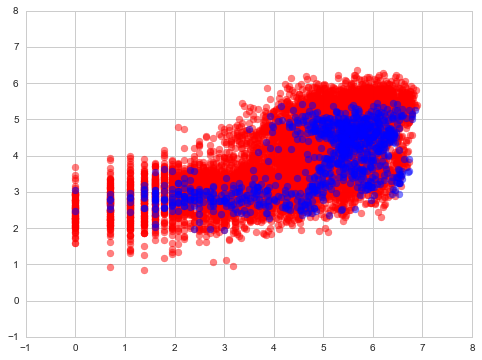

In [326]:
plt.figure(figsize=(8, 6))
plt.grid(True)
plt.xlim(-1, 8)
plt.ylim(-1, 8)
plt.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
plt.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')

### Другая модель

In [327]:
from sklearn.ensemble import RandomForestRegressor

In [328]:
regressor = RandomForestRegressor(random_state = 0, max_depth = 20, n_estimators = 50)

In [329]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0, with_std = 1))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [330]:
estimator.fit(train_data, train_labels)

Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x00000177EFA399D8>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
         ..._estimators=50, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [331]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

0.4787301194817357

In [332]:
test_labels[:10]

array([6.263, 6.727, 5.872, 5.403, 5.429, 5.784, 5.793, 5.73 , 5.846,
       6.1  ])

In [333]:
estimator.predict(test_data)[:10]

array([5.924, 6.142, 5.52 , 5.059, 5.3  , 5.488, 5.416, 5.423, 5.437,
       5.905])

Text(0.5,1,'random forest model')

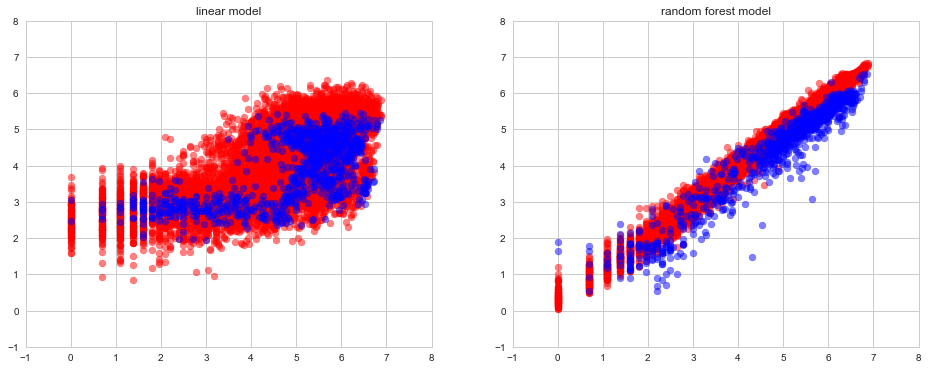

In [334]:
plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
plt.grid(True)
plt.xlim(-1, 8)
plt.ylim(-1, 8)
plt.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
plt.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
plt.title('linear model')

plt.subplot(1,2,2)
plt.grid(True)
plt.xlim(-1, 8)
plt.ylim(-1, 8)
plt.scatter(train_labels, estimator.predict(train_data), alpha=0.5, color = 'red')
plt.scatter(test_labels, estimator.predict(test_data), alpha=0.5, color = 'blue')
plt.title('random forest model')

### Predict on test data

In [335]:
cols = [col for col in raw_data.columns if col not in {'datetime', 'registered', 'casual'}]

t = raw_data.loc[:, cols]
t.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,month,week,hour
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.161126,0.971524,0.939284,-0.006546
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,-0.000435,0.001731,0.000976,-0.000354
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.018126,-0.003394,-0.022593,0.002780
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.106078,0.012144,0.019762,-0.022740
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.373913,0.257589,0.240794,0.145430
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.369587,0.264173,0.248653,0.140343
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.327998,0.204537,0.216435,-0.278011
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.120310,-0.150192,-0.145962,0.146631
count,0.161126,-0.000435,-0.018126,-0.106078,0.373913,0.369587,-0.327998,0.120310,1.000000,0.164262,0.147424,0.568961
month,0.971524,0.001731,-0.003394,0.012144,0.257589,0.264173,0.204537,-0.150192,0.164262,1.000000,0.961809,-0.006818


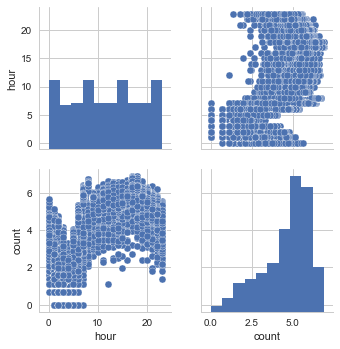

In [336]:
pairplot_cols = ['hour', 'count']

sns.pairplot(raw_data.loc[:, pairplot_cols])

In [337]:
def prepare_data(path_to_file):
    raw_data = pd.read_csv(path_to_file, header = 0, sep = ',')

    raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)
    raw_data['month'] = raw_data.datetime.dt.month
    raw_data['week'] = raw_data.datetime.dt.week
    raw_data['hour'] = raw_data.datetime.dt.hour
    datetime_data = raw_data.datetime.values
    raw_data = raw_data.drop(['datetime'], axis = 1)
    return raw_data, datetime_data

raw_test_data, datetime_data = prepare_data('data/13_14_bike_sharing_demand_test.csv')

In [347]:
def get_predictions(estimator, data):
    return np.exp(estimator.predict(data))

test_submit_predictions = get_predictions(estimator, raw_test_data)

In [348]:
submission = pd.DataFrame({'datetime': datetime_data, 'count': test_submit_predictions})
submission.head()

,datetime,count
0,2011-01-20 00:00:00,14.667255
1,2011-01-20 01:00:00,5.567901
2,2011-01-20 02:00:00,4.035530
3,2011-01-20 03:00:00,3.406848
4,2011-01-20 04:00:00,2.425312


In [349]:
# you could use any filename. We choose submission here
submission.to_csv('out/13_14_bike_sharing_demand_submission.csv', index=False)